## Codes for modeling coupling maps

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import hcipy as hc
from scipy.optimize import minimize
import cv2

In [32]:
N=3 # 3-port
zaber_res = 0.047625 # zaber step in microns

def gaussian2d(xg, yg, sig, x0=0, y0=0):
    ''' make 2D gaussian, real-valued '''
    return np.exp(-(((xg-x0)/sig)**2 + ((yg-y0)/sig)**2)/2)

def transform_lpmodes(lpfields, params, nf = 85):
    
    ''' perform linear transformation of LP modes - rotation, translation, and scale.
        params = [rotation angle, scale, dx, dy] '''
    [rot_angle, scale, dx, dy] = params

    rot_mat = cv2.getRotationMatrix2D((nf/2, nf/2), rot_angle, scale)
    tran_mat = np.float32([[1, 0, dx],
                        [0, 1, dy]])
    lpmodes = []
    for i in range(3):
        im = lpfields[i].reshape((nf,nf))
        shifted = cv2.warpAffine(im , rot_mat, dsize=(nf,nf))
        shifted = cv2.warpAffine(shifted, tran_mat, dsize=(nf,nf))
        lpmodes.append(shifted)

    return np.array(lpmodes)

def compute_overlap(beam, lpmodes, normfac):
    ''' compute overlaps (PSF and LP modes)'''
    overlapm = []
    for i in range(N):
        for j in np.arange(i,N):
            overlapm.append(np.sum(beam * lpmodes[i].flatten()) * np.sum(beam * lpmodes[j].flatten()) / normfac) 
    return np.array(overlapm)

def compute_overlaps_map(lpfields, focal_grid, LPparams, gauss_sigma, xgrid, ygrid, nf=85):

    ''' compute overlap coefficients for fixed lp modes and PSF width.
    args:
        - lpfields    : input LP fields
        - focal_grid  : focal grid. should match the focal grid computed for LP fields
        - LPparams    : params for transform_lpmodes
        - gauss_sigma : gaussian sigma for gaussian2d
        - xs          : list of PSF positions (x-axis)
        - ys          : list of PSF positions (y-axis)'''
    
    lpmodes = transform_lpmodes(lpfields, LPparams, nf=nf)
    refbeam = gaussian2d(focal_grid.x, focal_grid.y, gauss_sigma)
    normfac = np.sum(lpmodes[0]**2) * np.sum(refbeam**2)

    all_overlaps = np.zeros((len(xgrid), int(N*(N+1)/2)))

    for i, (x, y) in enumerate(zip(xgrid, ygrid)):
        beam = gaussian2d(focal_grid.x, focal_grid.y, gauss_sigma, x0=x, y0=y)
        overlapm = compute_overlap(beam, lpmodes, normfac)
        all_overlaps[i, :] = overlapm

    return all_overlaps

def find_coefficients(all_overlaps, measured_map):
    coeff = np.linalg.pinv(all_overlaps) @ measured_map
    return coeff

def model_couplingmap(measured_map, lpfields, LPparams, gauss_sigma, xgrid, ygrid, focal_grid,
                      plot=False):
    
    # compute overlaps
    all_overlaps = compute_overlaps_map(lpfields, focal_grid, LPparams, gauss_sigma, xgrid, ygrid)
    
    # find coefficients
    coeff = find_coefficients(all_overlaps, measured_map)

    # find modeled map
    model = np.array([(all_overlaps @ coeff).T[i] for i in range(N)]).T

    if plot:
        nmap = int(np.sqrt(len(xgrid)))

        fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(12,9))
        for i in range(3): axs[0][i].imshow(measured_map[:,i].reshape((nmap,nmap)), vmin=0, vmax=1, cmap='turbo')
        axs[0][3].imshow(np.sum(measured_map, axis=1).reshape((nmap,nmap)), cmap='turbo', vmin=0, vmax=1)

        for i in range(3): axs[1][i].imshow(model[:,i].reshape((nmap,nmap)), vmin=0, vmax=1, cmap='turbo')
        axs[1][3].imshow(np.sum(model, axis=1).reshape((nmap,nmap)), cmap='turbo', vmin=0, vmax=1)

        for i in range(3): axs[2][i].imshow(measured_map[:,i].reshape((nmap,nmap))-model[:,i].reshape((nmap,nmap)), vmin=-0.2, vmax=0.2, cmap='turbo')
        axs[2][3].imshow(np.sum(measured_map, axis=1).reshape((nmap,nmap))-np.sum(model, axis=1).reshape((nmap,nmap)), cmap='turbo', vmin=-0.2, vmax=0.2)
        
        return model, fig

    return model


class CouplingmapFitter:

    fix_scale = False
    fix_angle = False
    fix_beam = False
    constscale = 0
    constangle = 0

    def __init__(self, lpfields, focal_grid, xgrid, ygrid, verbose=False):

        self.lpfields = lpfields
        self.focal_grid = focal_grid
        self.xgrid = xgrid
        self.ygrid = ygrid
        self.verbose = verbose
    
    def find_beamsize(self, wcal, specind, slope = 0.0025):
        '''empirical beamsize scaled by wavelength'''
        return slope * wcal[1][np.where((wcal[0]) == specind)[0][0]]

    def compute_overlaps_map(self, LPparams, gauss_sigma):

        all_overlaps = compute_overlaps_map(self.lpfields, self.focal_grid, LPparams, gauss_sigma,
                                            self.xgrid, self.ygrid)
        
        return all_overlaps
    
    def model_couplingmap(self, measured_map, LPparams, gauss_sigma, plot=False):
        model = model_couplingmap(measured_map, self.lpfields, LPparams, gauss_sigma, 
                                  self.xgrid, self.ygrid, self.focal_grid, plot=plot)
        return model
    
    def residual(self, fitparams, measured_map):

        if self.fix_beam:
            [rot_angle, scale, dx, dy] = fitparams
            sig = self.constsig
            
        else:
            [sig, rot_angle, scale, dx, dy] = fitparams

        LPparams = [rot_angle, scale, dx, dy]
        model = self.model_couplingmap(measured_map, LPparams, sig)
        res = np.sum((model - measured_map)**2)
        if self.verbose:
            print('params:',fitparams, 'residual:',res)
        return res
    
    def optimization(self, ini_param, measured_map, method='Powell'):
        summed = np.sum(measured_map, axis=1)
        measured_map /= np.max(summed)

        opt = minimize(self.residual, ini_param, args=(measured_map), method=method)
        print(opt.message)
        print('optimal parameter: ', opt.x)
        print('residual: ', self.residual(opt.x, measured_map))

        return opt
    

In [33]:
data = fits.getdata('../data/coupling_map/specmap_600_50_20230808.fits')
wavs = np.load('../data/misc/wcal_20230807.npy')

xmin = 20 # minimum x value in pix (not in the range of wavelength solution)
xmax = 300 # maximum x value in pix (not in the range of wavelength solution)


In [34]:
lpfields0 = np.load('../data/misc/interpolated_field.npy')
focal_grid = hc.make_focal_grid(14, 3.05, f_number = 5, reference_wavelength = 1.55)

nf = 85
nmap = 13
maprange = np.linspace(-300 * zaber_res, 300 * zaber_res, nmap) 
xgrid, ygrid = np.meshgrid(maprange, maprange)

xgrid = xgrid.flatten()
ygrid = ygrid.flatten()

fitter = CouplingmapFitter(lpfields0, focal_grid, xgrid, ygrid, verbose=False)
fitter.fix_beam = True

Optimization terminated successfully.
optimal parameter:  [76.05254185  0.89591042 -1.13221826  0.29871578]
residual:  0.12131268623806045


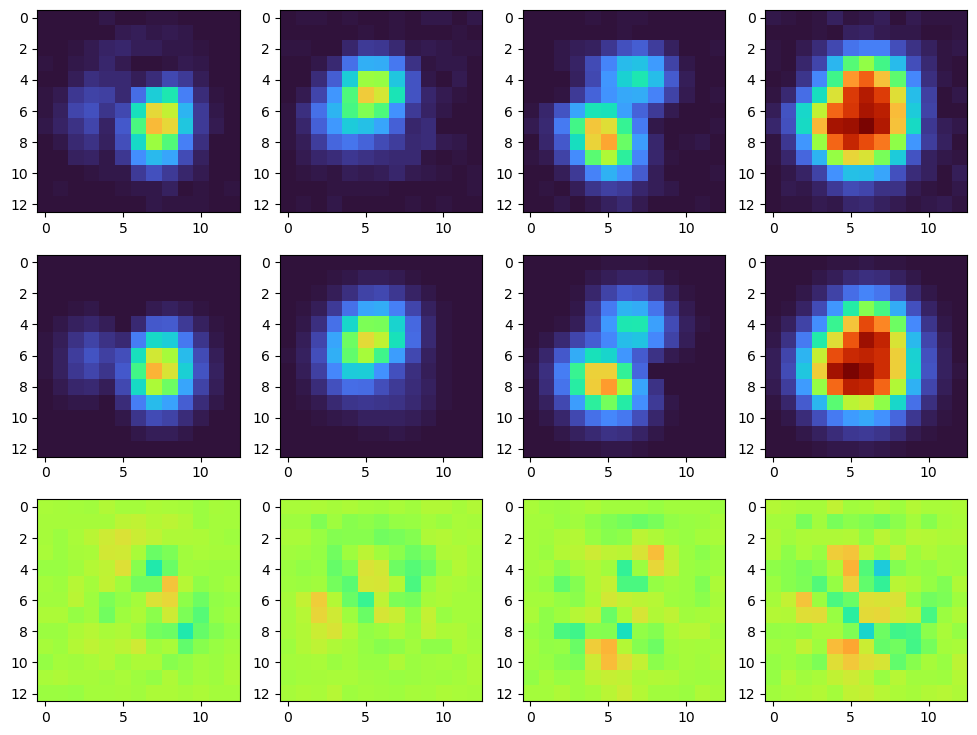

In [35]:
# select a wavelength channel
selected_specind = 233
measured_maps = np.array([data[:,i,selected_specind] / np.max(np.sum(data[:,:,selected_specind], axis=1)) for i in range(N)]).T


# initial parameters
rot_angle = -44
scale = 0.8 
dx = 0
dy = 0
beamsize = fitter.find_beamsize([np.arange(320), wavs], selected_specind) 

fitter.constsig = beamsize
ini_param = np.array([rot_angle, scale, dx, dy])

# do optimization
opt = fitter.optimization(ini_param, measured_maps)
fit_params = opt.x

# plot modeled coupling maps
modelmap, fig = fitter.model_couplingmap(measured_maps, opt.x, beamsize, plot=True)
plt.show()
